#### Imports

In [46]:
# Core imports
from copy import deepcopy

# Installed imports
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import matplotlib as mpl
import functools
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from sklearn.decomposition import PCA

# Local imports

#### Functions for loading data and some data re-arrangement

In [28]:
def load_demonstrations_file(filename):
    """ Load a .npz file containing a list of demonstrations.
        Returns a list of trajectories, each of which is a tuple containing a
        len_trajectory x num_states state matrix and a len_trajectory x num_controls control matrix. 
    """
    demonstrations = np.load(filename, allow_pickle=True)['demonstrations']
    return demonstrations

def load_centerlines(filename):
    data = np.load(filename)
    return data['lines']

centerlines = load_centerlines("./Data/LogAndLabelData/map_centerlines.npz")

def stack_demonstrations(demonstrations):
    state_matrices = [demonstration[0] for demonstration in demonstrations]
    control_matrices = [demonstration[1] for demonstration in demonstrations]
    return np.vstack(state_matrices), np.vstack(control_matrices)

#### Many helper functions for processing your trajectories, changing frame, etc.

In [29]:
def vehicle_index_to_col(index):
    return 4 + 4*index

def pedestrian_index_to_col(index, k_closest_vehicles):
    return 4 + 4*k_closest_vehicles + 4*index

def centerline_index(k_closest_vehicles, k_closest_pedestrians):
    return 4 + 4*k_closest_vehicles + 4*k_closest_pedestrians

def line_frame(state_matrix, k_closest_vehicles, k_closest_pedestrians):
    """ 
        Create a new state matrix where the x, y, theta for the ego vehicle, 
        other vehicles and pedestrians are all in the 
    """
    new_matrix = deepcopy(state_matrix)

    # Assert that the whole state matrix has the same centerline, which is the last 4 elements of each row
    assert np.all(state_matrix[:, -4:] == state_matrix[0, -4:])
    centerline = [state_matrix[0, -4:-2], state_matrix[0, -2:]]

    # Convert the ego vehicle state
    new_matrix[:, 0:4] = object_state_world_to_line_segment_frame(state_matrix[:, 0:4], centerline)

    # Convert the nearby vehicles
    for i in range(k_closest_vehicles):
        col_index = vehicle_index_to_col(i)
        cur_vehicle_state = state_matrix[:, col_index:col_index+4]
        new_matrix[:, col_index:col_index+4] = object_state_world_to_line_segment_frame(cur_vehicle_state, centerline)

    # Convert the nearby pedestrians
    for i in range(k_closest_pedestrians):
        col_index = pedestrian_index_to_col(i, k_closest_vehicles)
        cur_pedestrian_state = state_matrix[:, col_index:col_index+4]
        new_matrix[:, col_index:col_index+4] = object_state_world_to_line_segment_frame(cur_pedestrian_state, centerline)

    # Convert the line segment
    line_index = centerline_index(k_closest_vehicles, k_closest_pedestrians)
    new_matrix[:, line_index:line_index+4] = [0, 0, 0, np.linalg.norm(centerline[1] - centerline[0])]

    return new_matrix

def object_state_world_to_line_segment_frame(state_matrix, line_segment):
    """ 
        Convert an n x 4 state matrix to the frame given by a line segment.
    """
    # Get your x_hat, y_hat of the new frame from the line segment
    x1, y1 = line_segment[0]
    x2, y2 = line_segment[1]
    diff = np.array([x2 - x1, y2 - y1])
    y_hat = diff / np.linalg.norm(diff)

    # Rotate y_hat 90 degrees clockwise to get x_hat 
    x_hat = np.array([y_hat[1], -y_hat[0]])

    # Store your rotation matrix 
    R = np.array([x_hat, y_hat]) # put them in as rows of the matrix

    # Find the angle of rotation as well 
    x_hat_angle = np.arctan2(x_hat[1], x_hat[0])

    # Convert your position columns to the line frame, note origin of the line segment frame is x1, y1 of the line segment 
    new_state_matrix = np.zeros(state_matrix.shape)
    new_state_matrix[:, 0:2] = (state_matrix[:, 0:2] - np.array([x1, y1])) @ (R.T)
    new_state_matrix[:, 2] = state_matrix[:, 2] - x_hat_angle
    new_state_matrix[:, 3] = state_matrix[:, 3]
    
    return new_state_matrix 

def object_state_line_segment_to_world_frame(state_matrix, line_segment):
    # Get your x_hat, y_hat of the new frame from the line segment
    x1, y1 = line_segment[0]
    x2, y2 = line_segment[1]
    diff = np.array([x2 - x1, y2 - y1])
    y_hat = diff / np.linalg.norm(diff)

    # Rotate y_hat 90 degrees clockwise to get x_hat 
    x_hat = np.array([y_hat[1], -y_hat[0]])

    # Store your rotation matrix 
    R = np.array([x_hat, y_hat]) # put them in as rows of the matrix
    # Find the angle of rotation as well 
    x_hat_angle = np.arctan2(x_hat[1], x_hat[0])

    # Convert your position columns to the world frame, note origin of the line segment frame is x1, y1 of the line segment 
    new_state_matrix = np.zeros(state_matrix.shape)
    new_state_matrix[:, 0:2] = (state_matrix[:, 0:2] @ R) + np.array([x1, y1])

    # Convert your angle columns to the new frame by shifting by x_hat_angle appropriately
    new_state_matrix[:, 2] = state_matrix[:, 2] + x_hat_angle
    # Your speed column won't actually need to change
    new_state_matrix[:, 3] = state_matrix[:, 3]

    return new_state_matrix


def line_frame_to_network_input(state_line_frame, k_closest_vehicles, k_closest_pedestrians):
    """ 
        Given the state in a line frame, convert it to the input to the network.
        This will be: ego x, ego theta, ego speed,
                      vehicle x, vehicle y - ego y, vehicle theta, vehicle speed, ...,
                      pedestrian x, pedestrian y, pedestrian theta, pedestrian speed, ...
    """

    network_input = np.zeros((state_line_frame.shape[0], 3+4*k_closest_vehicles+4*k_closest_pedestrians))
    network_input[:, 0] = state_line_frame[:, 0] # x
    network_input[:, 1] = state_line_frame[:, 2] # theta
    network_input[:, 2] = state_line_frame[:, 3] # speed



    for i in range(k_closest_vehicles):
        network_input[:, 3+4*i] = state_line_frame[:, 4+4*i] # vehicle x 
        network_input[:, 3+4*i+1] = state_line_frame[:, 4+4*i+1] - state_line_frame[:, 1] # vehicle y relative to ego y  
        network_input[:, 3+4*i+2] = state_line_frame[:, 4+4*i+2] # vehicle theta
        network_input[:, 3+4*i+3] = state_line_frame[:, 4+4*i+3] # vehicle speed

    for i in range(k_closest_pedestrians):
        network_input[:, 3+4*k_closest_vehicles+4*i] = state_line_frame[:, 4+4*k_closest_vehicles+4*i] # pedestrian x
        network_input[:, 3+4*k_closest_vehicles+4*i+1] = state_line_frame[:, 4+4*k_closest_vehicles+4*i+1] - state_line_frame[:, 1] # pedestrian y relative to ego y
        network_input[:, 3+4*k_closest_vehicles+4*i+2] = state_line_frame[:, 4+4*k_closest_vehicles+4*i+2] # pedestrian theta
        network_input[:, 3+4*k_closest_vehicles+4*i+3] = state_line_frame[:, 4+4*k_closest_vehicles+4*i+3] # pedestrian speed

    return network_input

def network_output_to_line_frame(state_line_frame_0, state_line_frame_1, network_output):
    """ 
        Given a previous matrix of states in the line frame (state_line_frame_1), 
        and the ground truth state_line_frame from the time of the prediction, as well as
        the corresponding predictions from the network, return the new matrix of states in the line frame.

        The network output is given by the network as: delta_x, delta_y, delta_theta, delta_speed
    """
    # Update the ego state in state_line_frame_1 to correspond to the prediction
    new_state_line_frame = deepcopy(state_line_frame_1)
    new_state_line_frame[:, 0:4] = state_line_frame_1[:, 0:4] + network_output[:, 0:4]
    return new_state_line_frame

def find_normalization(X):
    """
        Return the mean and std to normalize a matrix by 
    """
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    return X_mean, X_std

def normalize_matrix(X, means, stdevs):
    """
        Normalize a matrix by subtracting the mean and dividing by the standard deviation
    """
    return (X - means) / stdevs

def unnormalize_matrix(X, means, stdevs):
    """
        Unnormalize a matrix by multiplying by the standard deviation and adding the mean
    """
    return X * stdevs + means

#### Setup some fairly general supervised learning code

In [30]:
def supervised_learning(X, Y, X_val, Y_val, model, n_epochs, batch_size, loss_fn, lr=0.001):
    # Create your optimizer
    optimizer=optim.Adam(model.parameters(), lr=lr)

    # Setup the dataloader 
    loader = DataLoader(list(zip(X, Y)), shuffle=True, batch_size=batch_size)

    # Keep track of training and validation losses
    train_losses = []
    val_losses = []

    # Train the model 
    for epoch in range(n_epochs):
        for X_batch, Y_batch in loader:
            
            # Predict, then calculate the loss
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)

            # Optimize using the gradient from that loss 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = loss_fn(model(X), Y)
        val_loss = loss_fn(model(X_val), Y_val)
        train_losses.append(train_loss.detach().numpy())
        val_losses.append(val_loss.detach().numpy())

        print(f'Finished epoch {epoch}, latest loss {train_loss}, validation loss {val_loss}') 

    plt.figure()
    plt.plot(range(n_epochs), train_losses, label='Training loss')
    plt.plot(range(n_epochs), val_losses, label='Validation loss')
    plt.legend()
    plt.xlabel("Epoch")
    plt.title("Training and Validation Loss vs. Epoch")
    plt.show()
    

#### Load train, validation, and test demonstration trajectories 

In [31]:
k_closest_vehicles = 6
k_closest_pedestrians = 0

train_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/train_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
validation_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/validation_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
test_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/test_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")

#### Do any pre-processing to the state that we'd like. For instance, here we can turn things into an ego-centric frame.


In [33]:
 # Convert demonstrations to line frame 
 train_demonstration_states_world_frame = [demonstration[0] for demonstration in train_demonstrations]
 validation_demonstration_states_world_frame = [demonstration[0] for demonstration in validation_demonstrations]

 train_demonstration_states_line_frame = [line_frame(demonstration, k_closest_vehicles, k_closest_pedestrians) for demonstration in train_demonstration_states_world_frame]
 validation_demonstration_states_line_frame = [line_frame(demonstration, k_closest_vehicles, k_closest_pedestrians) for demonstration in validation_demonstration_states_world_frame]

#### Create outputs your input, output pairs for training.

For now, these will be state-based for the ego vehicle but this could also be the control actions. It's like we're picturing the control-space as the next 2-d position, angle, and speed. 

In [34]:
def prediction_input_and_output(X, prediction_steps, cols_to_predict):
    """ 
        Take in a num_samples x num_features matrix X. Return a matrix Y
        such that it's X with the first prediction_steps rows removed and only the cols_to_predict, and 
        return an X with the last prediction_steps removed, corresponding to 
        each row in X being used to predict another row in X prediction_steps later 
    """
    Y = X[prediction_steps:, cols_to_predict]
    new_X = X[:-prediction_steps, :]
    return new_X, Y

def line_frame_to_training_matrices(state_matrix_line_frame, k_closest_vehicles, k_closest_pedestrians, prediction_steps):
    """ 
        Each input output pair we'd like to be:
            input: a row from state_matrix_line_frame but without the ego y position, 
                    and converting the vehicle and pedestrian y positions to be relative to the ego y position.
                    also, remove the centerline state from the row. 

            output: the line frame delta_x, delta_y, delta_theta, and delta_speed between the row
                    in the input and a row prediction_steps later
    """

    # Pull out the appropriate parts as the input
    X_train = line_frame_to_network_input(state_matrix_line_frame, k_closest_vehicles, k_closest_pedestrians)

    # The label is the difference between the ego state now and prediction_steps later
    Y_train = state_matrix_line_frame[prediction_steps:, 0:4] - state_matrix_line_frame[0:-prediction_steps, 0:4]

    # Except for theta, which we'd like to just be the absolute next theta (but cos (theta) to avoid weird 2pi things?)
    Y_train[:, 2] = np.cos(state_matrix_line_frame[prediction_steps:, 2])

    # Mod the difference in theta by 2pi
    # Y_train[:, 2] = Y_train[:, 2] % (2 * np.pi)

    # Appropriately truncate X_train
    X_train = X_train[0:-prediction_steps, :]
    return X_train, Y_train

In [35]:
# Depending on whether we'd like to do world frame or line frame
world_frame = False
n_steps_ahead = 10

if world_frame:
    # How far ahead you're trying to predict and which columns you'd like to predict
    cols_to_predict = [0, 1, 2, 3]
    training_pairs = [prediction_input_and_output(demonstration, n_steps_ahead, cols_to_predict) for demonstration in train_demonstration_states_world_frame]
    validation_pairs = [prediction_input_and_output(demonstration, n_steps_ahead, cols_to_predict) for demonstration in validation_demonstration_states_world_frame]

else:
    # Get X, Y matrices from each demonstration
    training_pairs = [line_frame_to_training_matrices(demonstration_line_frame, k_closest_vehicles, k_closest_pedestrians, n_steps_ahead) for demonstration_line_frame in train_demonstration_states_line_frame]
    validation_pairs = [line_frame_to_training_matrices(demonstration_line_frame, k_closest_vehicles, k_closest_pedestrians, n_steps_ahead) for demonstration_line_frame in validation_demonstration_states_line_frame]
    
# Then, stack these X, Y pairs to get the final training data
X_train = np.vstack([pair[0] for pair in training_pairs])
Y_train = np.vstack([pair[1] for pair in training_pairs])   
X_validation = np.vstack([pair[0] for pair in validation_pairs])
Y_validation = np.vstack([pair[1] for pair in validation_pairs])

# Normalize the data, both train and validation
X_train_mean, X_train_std = find_normalization(X_train)
Y_train_mean, Y_train_std = find_normalization(Y_train)

X_train = normalize_matrix(X_train, X_train_mean, X_train_std)
Y_train = normalize_matrix(Y_train, Y_train_mean, Y_train_std)

X_validation = normalize_matrix(X_validation, X_train_mean, X_train_std)
Y_validation = normalize_matrix(Y_validation, Y_train_mean, Y_train_std)

#### Create our model. We'll start with a simple MLP 

In [36]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, act=nn.Tanh(), output_act=nn.Identity()):
        super().__init__()
        self.act = act
        self.output_act = output_act

        self.layers = []
        self.acts = []

        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if i < len(layer_sizes) - 2:
                self.acts.append(act)
            else:
                self.acts.append(output_act)

        self.layers = nn.ModuleList(self.layers)
        self.acts = nn.ModuleList(self.acts)
                
    def forward(self, x):
        for (layer, act) in zip(self.layers, self.acts):
            x = act(layer(x))
        return x

Finished epoch 0, latest loss 4.260551929473877, validation loss 37.87709045410156
Finished epoch 1, latest loss 3.841571092605591, validation loss 36.603267669677734
Finished epoch 2, latest loss 3.408618927001953, validation loss 35.24103927612305
Finished epoch 3, latest loss 2.9371869564056396, validation loss 33.68680191040039
Finished epoch 4, latest loss 2.4256057739257812, validation loss 31.890846252441406
Finished epoch 5, latest loss 1.8843741416931152, validation loss 29.822216033935547
Finished epoch 6, latest loss 1.3538728952407837, validation loss 27.53863525390625
Finished epoch 7, latest loss 0.8893176317214966, validation loss 25.180448532104492
Finished epoch 8, latest loss 0.540178656578064, validation loss 22.95244026184082
Finished epoch 9, latest loss 0.32076916098594666, validation loss 21.057430267333984
Finished epoch 10, latest loss 0.2082848846912384, validation loss 19.622451782226562
Finished epoch 11, latest loss 0.15904156863689423, validation loss 18.5

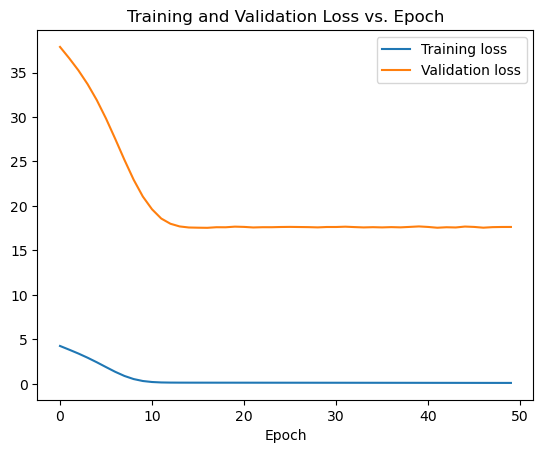

In [37]:
x_dimension = 8
n_datapoints = 100
X = np.random.random([n_datapoints, x_dimension])
X_val = np.random.random([n_datapoints, x_dimension])

A = np.random.rand(x_dimension, 3)
A_val = A + 1**np.random.random([x_dimension, 3]) # slightly different A for validation

Y = X@A + 0.1*np.random.random([n_datapoints, 1]) # noisy linear generation of data
Y_val = X@A_val + 0.1*np.random.random([n_datapoints, 1]) # noisy linear generation of data

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

model = MLP([x_dimension, 10, 20, 3])
loss_fn = nn.MSELoss()
supervised_learning(X, Y, X_val, Y_val, model, 50, 10, loss_fn)

Apply supervised learning to map between our X and Y

In [38]:
X_train.shape

(9327, 27)

Finished epoch 0, latest loss 0.7683032751083374, validation loss 0.9467777013778687
Finished epoch 1, latest loss 0.7377914190292358, validation loss 0.9239366054534912
Finished epoch 2, latest loss 0.7071488499641418, validation loss 0.9335339665412903
Finished epoch 3, latest loss 0.6702311635017395, validation loss 0.9213185906410217
Finished epoch 4, latest loss 0.635236382484436, validation loss 0.8751227259635925
Finished epoch 5, latest loss 0.5930401086807251, validation loss 0.9028539061546326
Finished epoch 6, latest loss 0.5487909317016602, validation loss 0.8831324577331543
Finished epoch 7, latest loss 0.5177963376045227, validation loss 0.8928713798522949
Finished epoch 8, latest loss 0.4844629466533661, validation loss 0.9376064538955688
Finished epoch 9, latest loss 0.45841333270072937, validation loss 0.9455304741859436


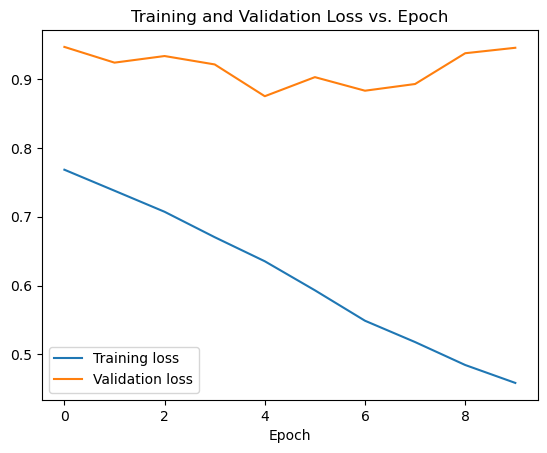

In [39]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_validation = torch.tensor(X_validation, dtype=torch.float32)
Y_validation = torch.tensor(Y_validation, dtype=torch.float32)

model = MLP([X_train.shape[1], 32, 32, Y_train.shape[1]])
supervised_learning(X_train, Y_train, X_validation, Y_validation, model, 10, 64, nn.MSELoss(), lr=0.001)

Text(0.5, 1.0, 'Validation error y histogram')

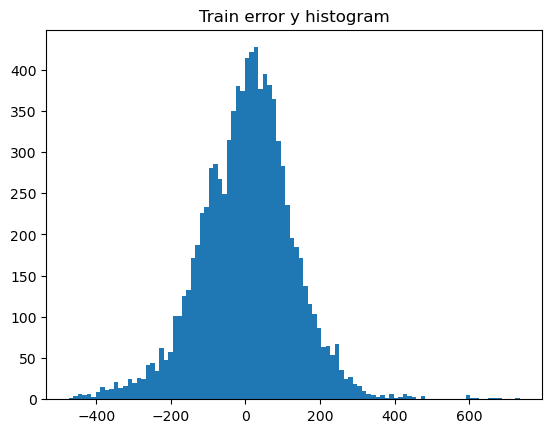

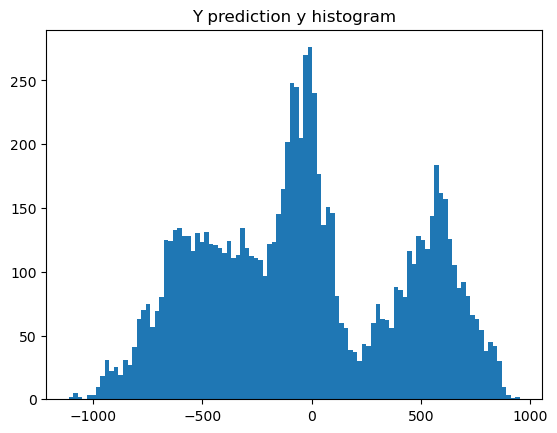

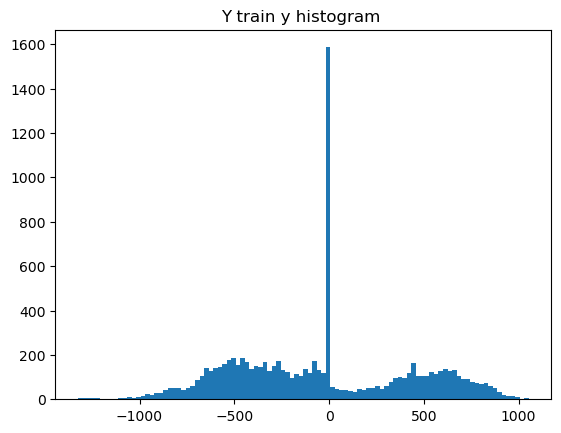

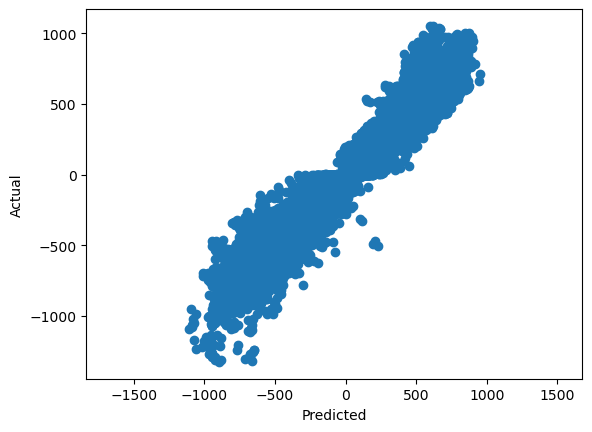

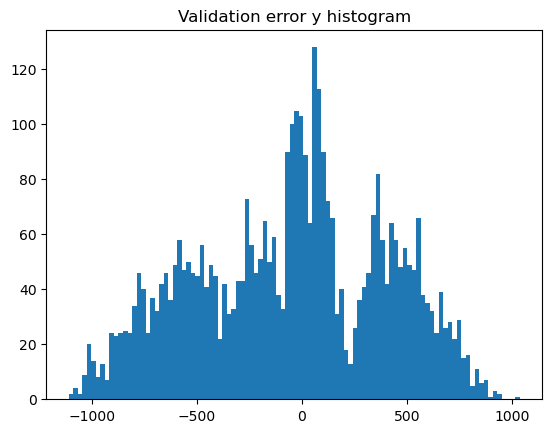

In [40]:
Y_pred = model(X_train).detach().numpy()
unnormalized_Y_pred = unnormalize_matrix(Y_pred, Y_train_mean, Y_train_std)
unnormalized_Y_train = unnormalize_matrix(Y_train.detach().numpy(), Y_train_mean, Y_train_std)

unnormalized_train_errors = unnormalized_Y_pred - unnormalized_Y_train

Y_pred_validation = model(X_validation).detach().numpy()
unnormalized_Y_pred_validation = unnormalize_matrix(Y_pred_validation, Y_train_mean, Y_train_std)

# histogram of train errors in the first index
plt.figure()
plt.hist(unnormalized_train_errors[:, 1], bins=100)
plt.title("Train error y histogram")

plt.figure()
plt.hist(unnormalized_Y_pred[:, 1], bins=100)
plt.title("Y prediction y histogram")

plt.figure()
plt.hist(unnormalized_Y_train[:, 1], bins=100)
plt.title("Y train y histogram ")

plt.figure()
plt.plot(unnormalized_Y_pred[:, 1], unnormalized_Y_train[:, 1], 'o')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.axis('equal')

# Histogram of validation errors in the first index
plt.figure()
plt.hist(unnormalized_Y_pred_validation[:, 1] - Y_validation[:, 1].detach().numpy(), bins=100)
plt.title("Validation error y histogram")

#### Helper functions for plotting and examining the learned model

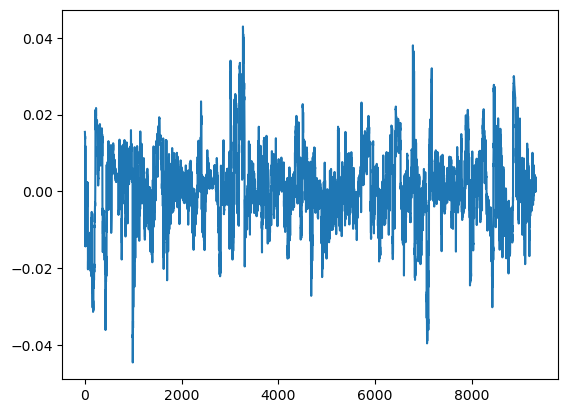

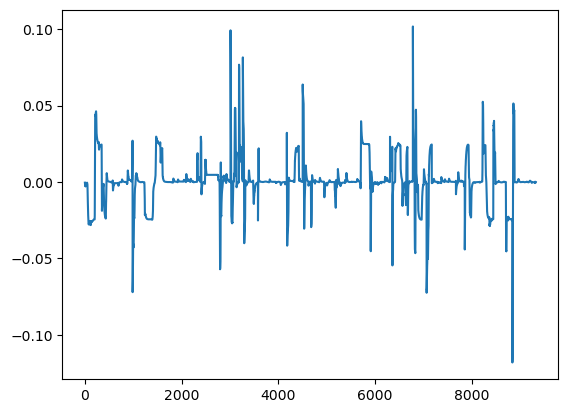

In [41]:
Y_pred_train = model(X_train).detach().numpy()
Y_pred_train = unnormalize_matrix(Y_pred_train, Y_train_mean, Y_train_std)
plt.plot(Y_pred_train[0:, 2])
plt.figure()
Y_train_unnormalized = unnormalize_matrix(Y_train, Y_train_mean, Y_train_std)
plt.plot(Y_train_unnormalized[0:, 2].detach().numpy())

In [42]:
def plot_line_segment(line, color='black', index=0, plot_index=False):
    x1, y1 = line[0]
    x2, y2 = line[1]
    plt.plot([x1, x2], [y1, y2], color, linewidth=1)
    if plot_index: 
        # write the number i next to each line
        plt.text((x1+x2)/2, (y1+y2)/2, str(index), fontsize=10, color='red')

def plot_road_segment(line, color='black'):
    road_width = 1200
    x1, y1 = line[0]
    x2, y2 = line[1]
    # The centerline 
    plot_line_segment(line, color='y-')
    # A line road_width/2 to the left of the first line
    plot_line_segment([[x1-road_width/2, y1], [x2-road_width/2, y2]], color)
    # A line road_width/2 to the right of the first line
    plot_line_segment([[x1+road_width/2, y1], [x2+road_width/2, y2]], color)

def visualize_map(centerlines):
    for i, line in enumerate(centerlines):
        plot_line_segment(line, i+1)

def visualize_prediction(state_matrix, model, X_mean, X_stdev, Y_mean, Y_std, n_steps_ahead):
    xs_groundtruth = state_matrix[:, 0]
    ys_groundtruth = state_matrix[:, 1]

    n_steps = int(state_matrix.shape[0] / n_steps_ahead)
    ego_states = np.zeros((n_steps, 4))

    print("n steps: ", n_steps)


    cur_ego_state = state_matrix[0, 0:4]
    for i in range(n_steps):
        # Record the ego state that you're at
        ego_states[i, :] = cur_ego_state

        # Start with the ground truth state 
        input_features = state_matrix[[n_steps_ahead*i], :] # list on [n_steps_ahead * i] to preserve dimensionality

        # Replace the prediction for the current x, y, angle, and speed 
        input_features[0, 0:4] = cur_ego_state

        # Normalize your input features, cast to a torch tensor, then pass through the model
        normalized_input = torch.tensor(normalize_matrix(input_features, X_mean, X_stdev), dtype=torch.float32)
        ego_next_normalized = model(normalized_input)
        ego_next_normalized = ego_next_normalized.detach().numpy()

        # unnormalize the output and then update your current ego state
        ego_next = unnormalize_matrix(ego_next_normalized, Y_mean,  Y_std)
        cur_ego_state = ego_next
    
    plt.figure()
    plt.plot(xs_groundtruth, ys_groundtruth, label='Ground truth trajectory')
    plt.plot(ego_states[:, 0], ego_states[:, 1], label='Predicted trajectory', color='r', linestyle='dashed')
    plt.axis('equal')
    plt.legend()

def rollout_prediction_line_frame(state_matrix_line_frame, model, X_mean, X_stdev, Y_mean, Y_std, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians):
    # Now, find the number of steps we'll take in the sim
    n_steps = int(state_matrix_line_frame.shape[0] / n_steps_ahead)

    # Keep track of the ego_states in the line frame
    ego_states = np.zeros((n_steps, 4))
    cur_ego_state = state_matrix_line_frame[0, 0:4]
    for i in range(n_steps):
        # # Temporary keep the true theta to see what happens
        # cur_ego_state[2] = state_matrix_line_frame[n_steps_ahead*i, 2]

        # Record the ego state that you're at
        ego_states[i, :] = cur_ego_state 

        # Get the current state from the demonstration
        line_frame_state = state_matrix_line_frame[[n_steps_ahead*i], :]
        # Replace the ego state with the one you're predicting
        line_frame_state[:, 0:4] = cur_ego_state


        # Convert to a format you can input to the network
        network_input = line_frame_to_network_input(line_frame_state, k_closest_vehicles, k_closest_pedestrians)
        network_input = normalize_matrix(network_input, X_mean, X_stdev)
        network_input = torch.tensor(network_input, dtype=torch.float32)

        # Run through the model
        network_output = model(network_input).detach().numpy()
        network_output = unnormalize_matrix(network_output, Y_mean, Y_std)
        assert network_output.shape == (1, 4)

        # Update your ego state 
        cur_ego_state[0:2] = cur_ego_state[0:2] + network_output[0, 0:2]
        cur_ego_state[2] = np.arccos(network_output[0, 2]) # just have the network predict absolute instead of delta, and also predict cos(theta) instead of theta itself
        cur_ego_state[3] = cur_ego_state[3] + network_output[0, 3]


    return ego_states

def visualize_prediction_line_frame(state_matrix_line_frame, model, X_mean, X_stdev, Y_mean, Y_std, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians):
    """ 
        Visualize a trajectory predicted by the model being applied repeatedly
    """
    # First find the groundtruth xs and ys in the line frame 
    xs_groundtruth = state_matrix_line_frame[:, 0]
    ys_groundtruth = state_matrix_line_frame[:, 1]

    ego_states = rollout_prediction_line_frame(state_matrix_line_frame, model, X_mean, X_stdev, Y_mean, Y_std, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians)
    
    plt.figure()
    plt.plot(xs_groundtruth, ys_groundtruth, label='Ground truth trajectory')
    plt.plot(ego_states[:, 0], ego_states[:, 1], label='Predicted trajectory', color='r', linestyle='dashed')
    plt.axis('equal')
    plt.legend()

    return ego_states


def plot_car_at_position(position, heading, color, label):
    ax = plt.gca()
    width = 400 
    height = 200
    box = patches.Rectangle((position[0] - width/2, position[1] - height/2), width, height, color=color, alpha=1.0)
    rotation = mpl.transforms.Affine2D().rotate_around(position[0], position[1], heading) + ax.transData
    box.set_transform(rotation)
    ax.add_patch(box)


def plot_pedestrian_at_position(position, color, label):
    ax = plt.gca() 
    radius = 200
    circle = patches.Circle((position[0], position[1]), radius=radius)
    ax.add_patch(circle)

def animation_frame(frame_num, state_matrix_demonstration, ego_states_prediction, k_closest_vehicles, k_closest_pedestrians, n_steps_ahead):
    # Clear the current axis
    plt.cla()

    demonstration_frame = frame_num*n_steps_ahead
    # Plot the ground truth trajectory
    cur_state = state_matrix_demonstration[demonstration_frame, :]
    plot_car_at_position(cur_state[0:2], cur_state[2], 'black', 'Ground truth trajectory')

    # Plot the predicted ego vehicle
    cur_pred_ego = ego_states_prediction[frame_num, :]
    plot_car_at_position(cur_pred_ego[0:2], cur_pred_ego[2], 'r', 'Predicted trajectory')


    # Plot the other vehicles
    for i in range(k_closest_vehicles):
        vehicle_index = vehicle_index_to_col(i)
        vehicle_pos = cur_state[vehicle_index:vehicle_index+2]
        vehicle_heading = cur_state[vehicle_index+2]
        plot_car_at_position(vehicle_pos, vehicle_heading, 'b', "Other Vehicles")

    # Plot the pedestrians
    for i in range(k_closest_pedestrians):
        pedestrian_index = pedestrian_index_to_row(i, k_closest_vehicles)
        pedestrian_pos = cur_state[pedestrian_index:pedestrian_index+2]
        plot_pedestrian_at_position(pedestrian_pos, 'b', 'Pedestrians')


    # Plot the road 
    road_width = 3600
    plot_road_segment([cur_state[-4:-2], cur_state[-2:]])


    # Set boundaries on the view
    fov_x = 10000
    fov_y = 10000

    # Add in text giving the time 
    t = demonstration_frame * 1/15
    ax = plt.gca()
    ax.text(cur_state[0] - 0.9*fov_x/2, cur_state[1] + 0.9*fov_y/2, "time = " + str(round(t, 1)))

    # Set xlim and ylim 
    ax.axis('equal')
    ax.set_xlim([cur_state[0] - fov_x/2, cur_state[0] + fov_x/2])
    ax.set_ylim([cur_state[1] - fov_y/2, cur_state[1] + fov_y/2])
    ax.invert_yaxis()
    

def animate_trajectory(state_matrix_demonstration, ego_states_prediction, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians, percent_to_animate=1.0, export_as_gif=False, export_as_mp4=False, filename="./Output/animation"):
    fig, axs = plt.subplots()

    fps = 10
    frames = int(percent_to_animate * len(ego_states_prediction))

    anim_interval = 1000/fps
    anim = FuncAnimation(fig, functools.partial(animation_frame, 
                                                state_matrix_demonstration=state_matrix_demonstration, 
                                                ego_states_prediction=ego_states_prediction, 
                                                k_closest_vehicles=k_closest_vehicles, 
                                                k_closest_pedestrians=k_closest_pedestrians,
                                                n_steps_ahead=n_steps_ahead),  
                                                frames=frames, interval=anim_interval, repeat=True)
    
    if export_as_gif:
        anim.save(filename+".gif", writer='imagemagick', fps=1/(anim_interval / 1000))
        return None
    elif export_as_mp4:
        anim.save(filename+".mp4", fps=1/(anim_interval / 1000))
    else:
        return HTML(anim.to_jshtml()) #, HTML(anim.to_html5_video())



In [43]:
# # Plot some world frame animations to debug the coord transform if 
# # that's why some weird neighbor stuff showing up 
# demonstration_states = train_demonstration_states_world_frame[0]
# ego_states_prediction = np.zeros((len(demonstration_states)//n_steps_ahead, 4))
# anim = animate_trajectory(demonstration_states, ego_states_prediction, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians, percent_to_animate=0.5, export_as_gif=True, filename="./Output/world_frame")
# anim

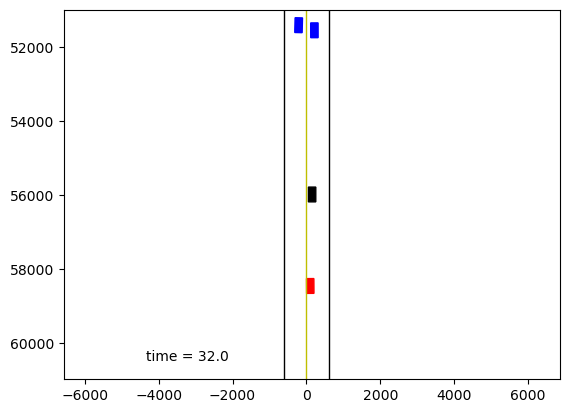

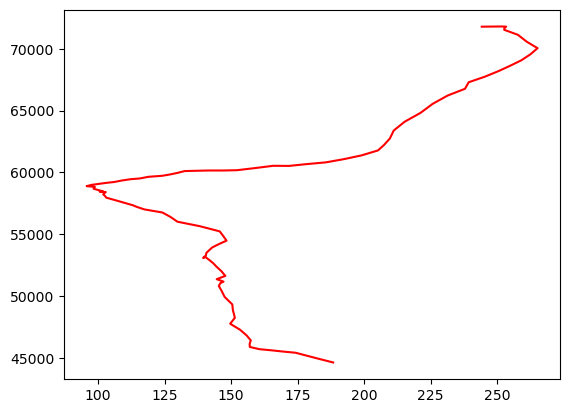

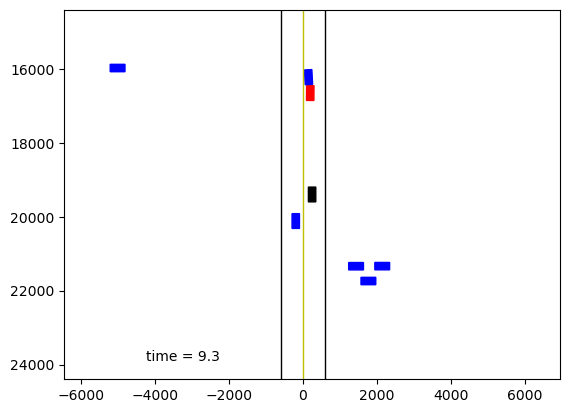

In [44]:
if ~world_frame:
    n_train_animations = 1
    n_validation_animations = 1
    export_as_gif = True
    percent_to_animate=0.5

    train_anims = []
    validation_anims = []
    for i in range(n_train_animations):
        demonstration_states = train_demonstration_states_line_frame[i]
        ego_states_prediction = rollout_prediction_line_frame(demonstration_states, model, X_train_mean, X_train_std, Y_train_mean, Y_train_std, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians)
        anim = animate_trajectory(demonstration_states, ego_states_prediction, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians, percent_to_animate=percent_to_animate, export_as_gif=export_as_gif, filename=f"./Output/animation_train_{i}")
        plt.figure()
        plt.plot(ego_states_prediction[:, 0], ego_states_prediction[:, 1], 'r')
        train_anims.append(anim)

    for i in range(n_validation_animations):
        demonstration_states = validation_demonstration_states_line_frame[i]
        ego_states_prediction = rollout_prediction_line_frame(demonstration_states, model, X_train_mean, X_train_std, Y_train_mean, Y_train_std, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians)
        anim = animate_trajectory(demonstration_states, ego_states_prediction, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians, percent_to_animate=percent_to_animate, export_as_gif=export_as_gif, filename=f"./Output/animation_validation_{i}")

        validation_anims.append(anim)

train_anims[0]
#validation_anims[0]


/var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/ipykernel_91660/887303005.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


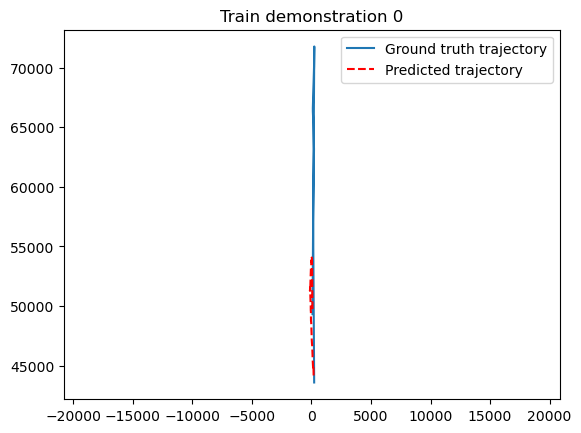

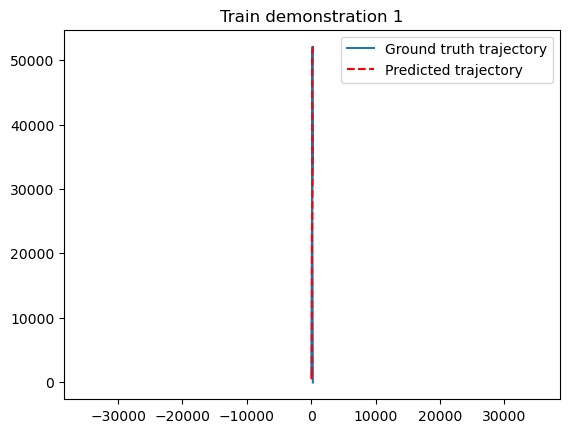

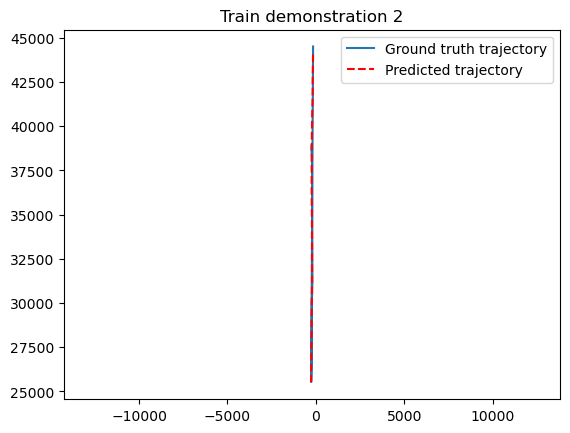

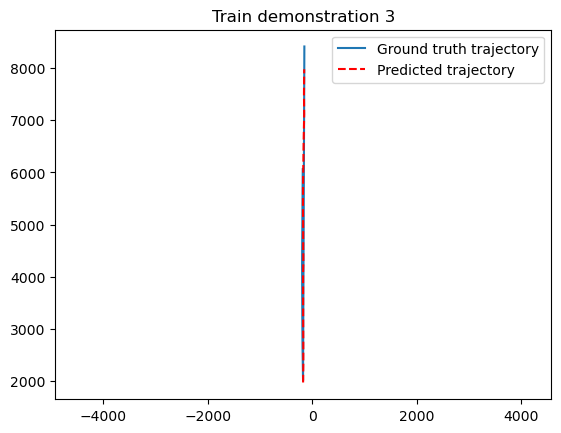

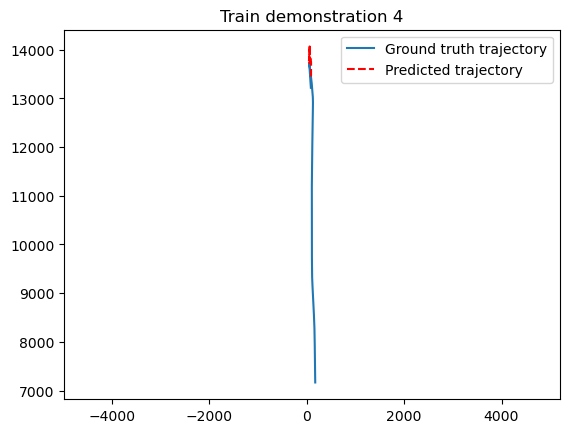

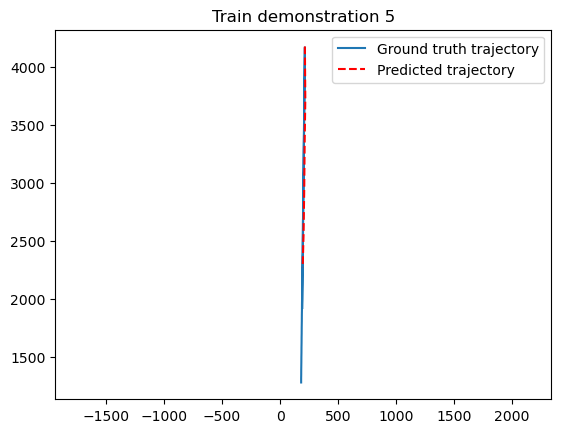

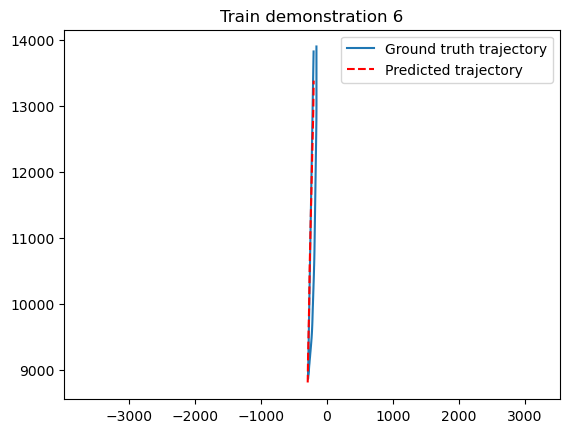

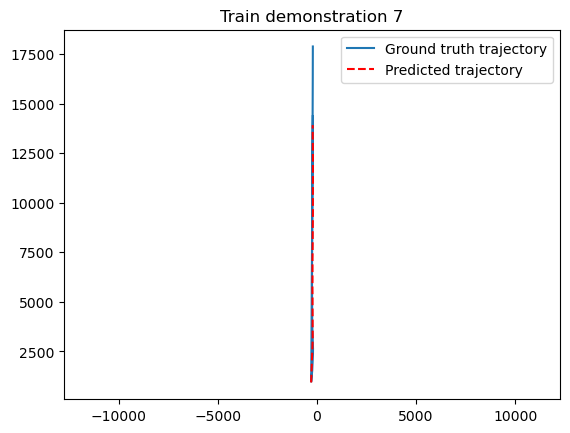

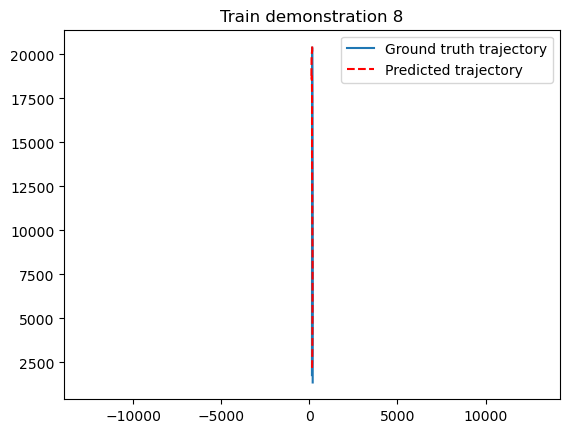

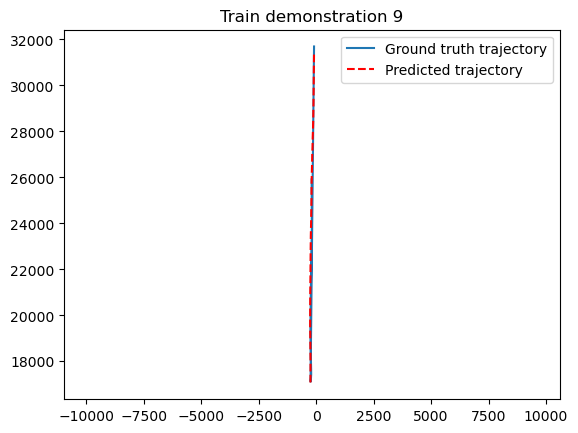

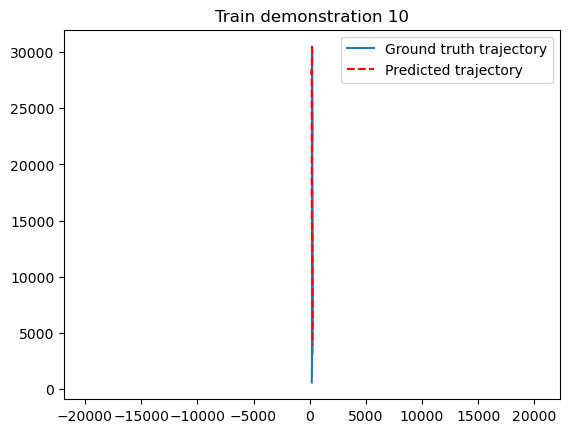

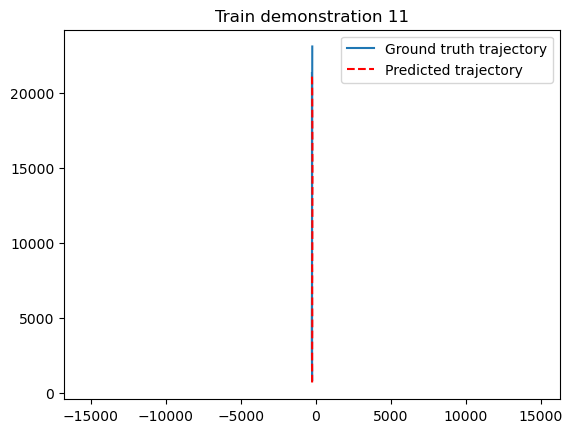

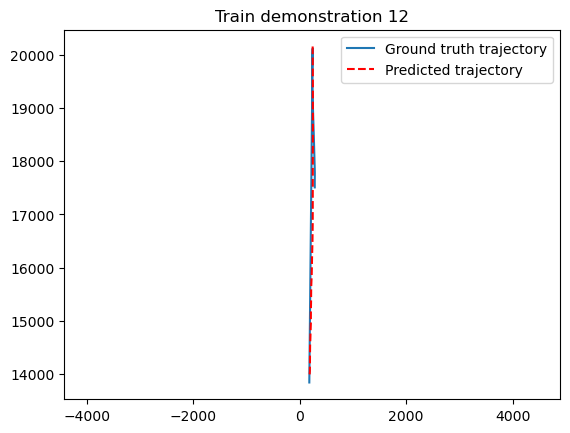

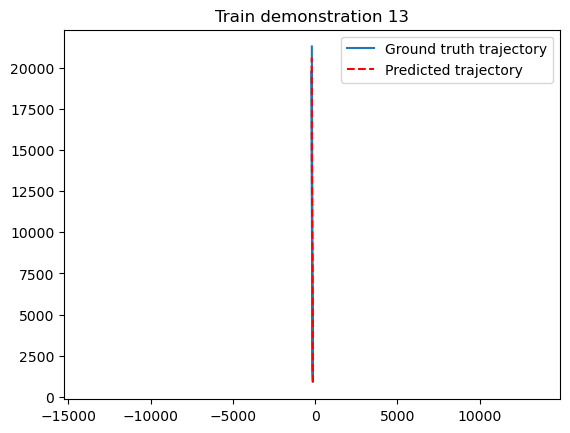

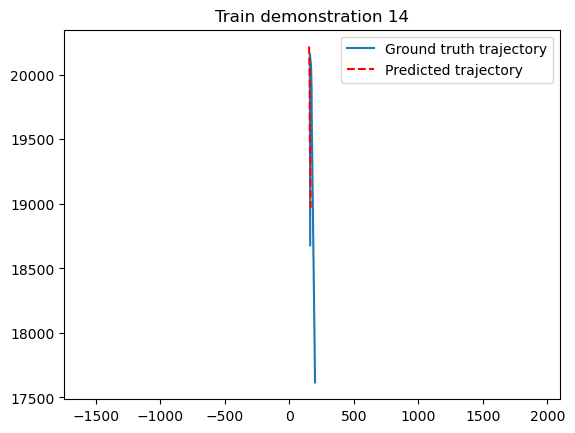

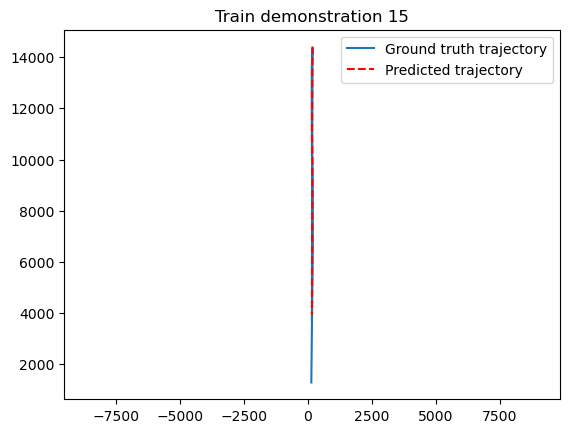

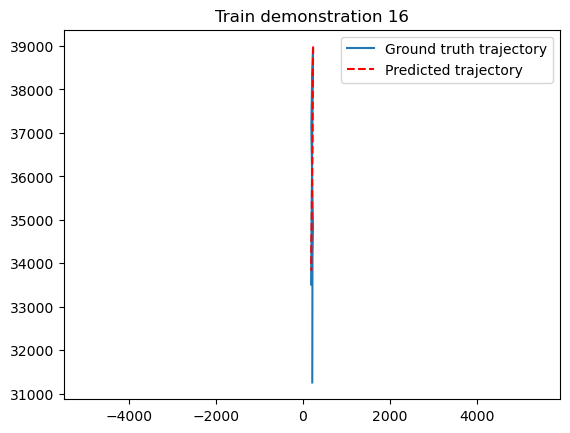

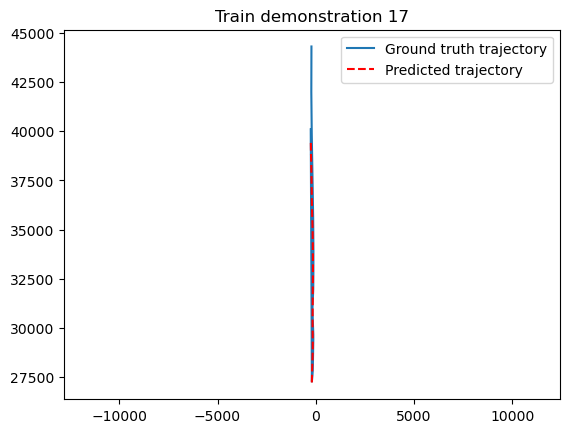

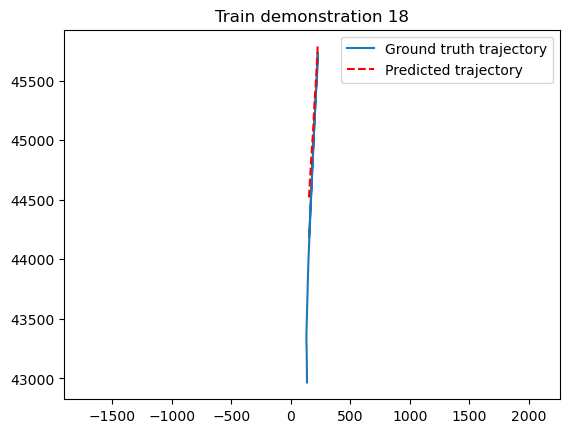

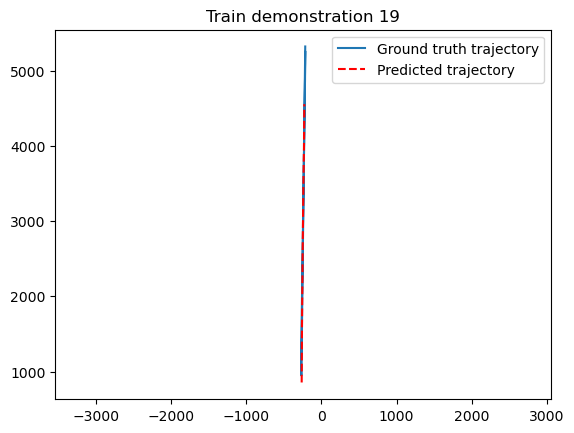

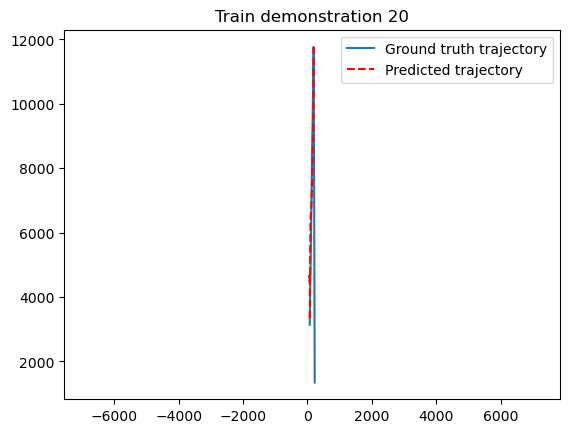

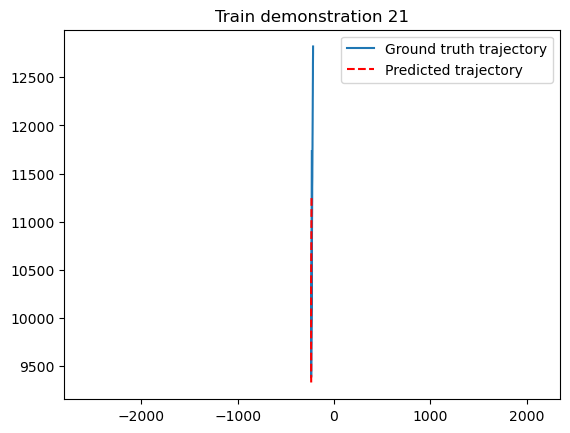

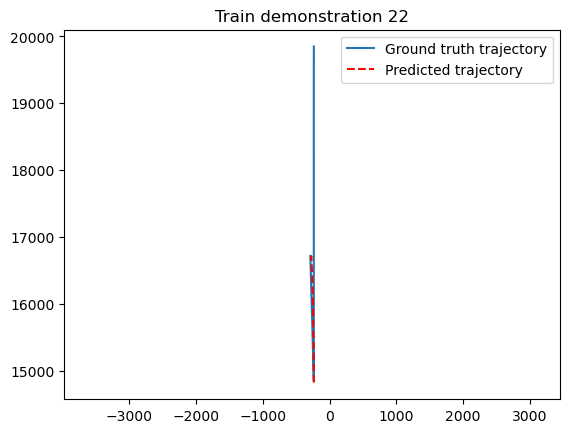

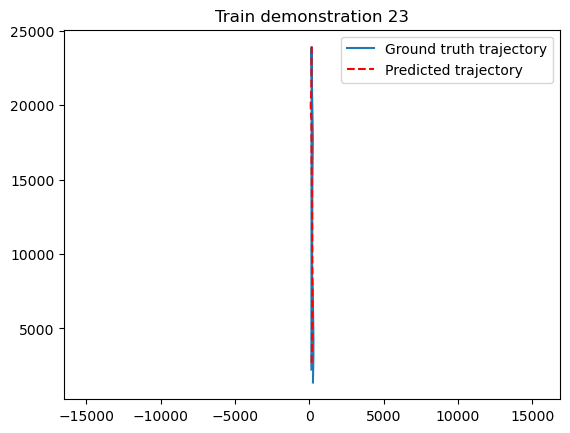

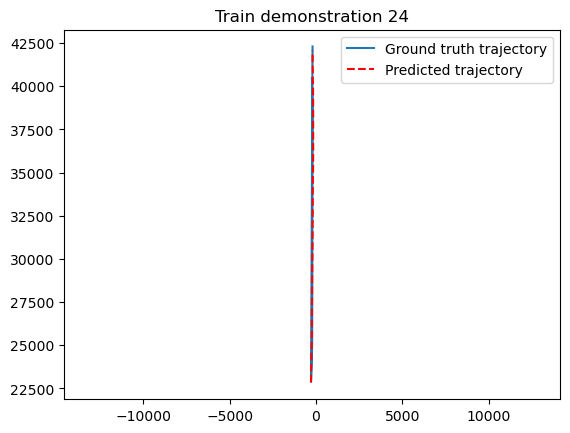

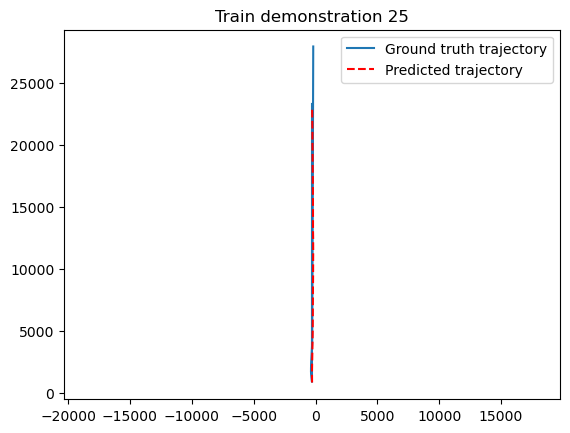

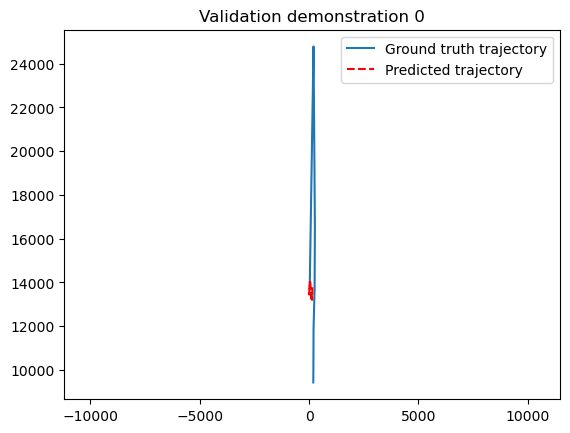

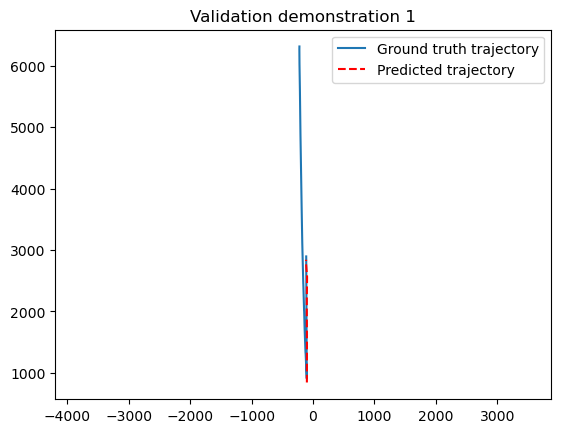

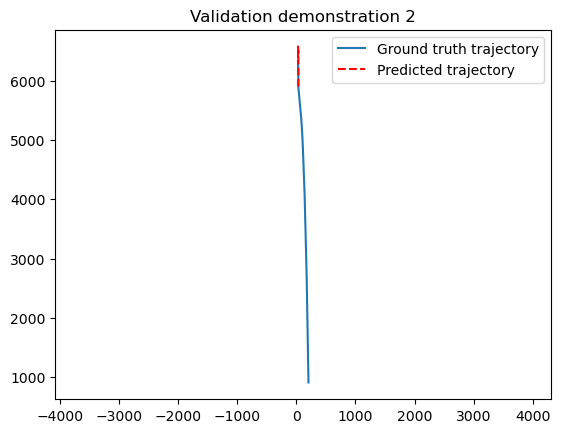

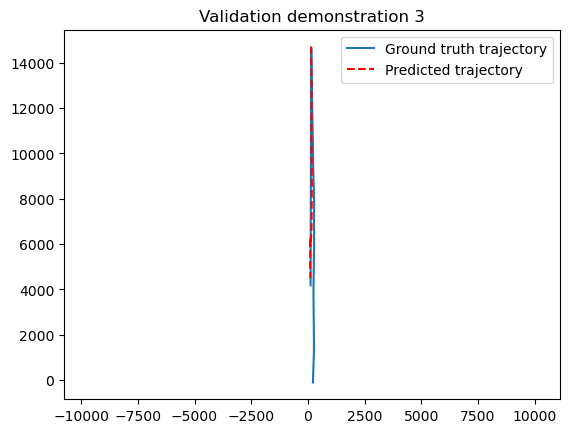

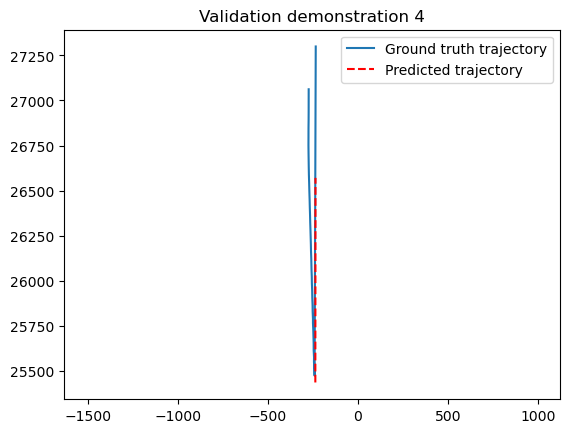

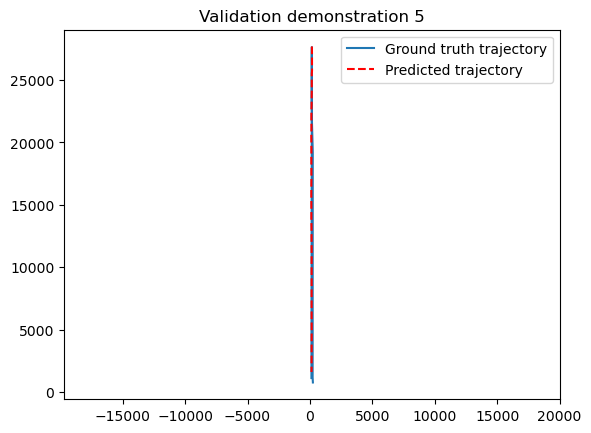

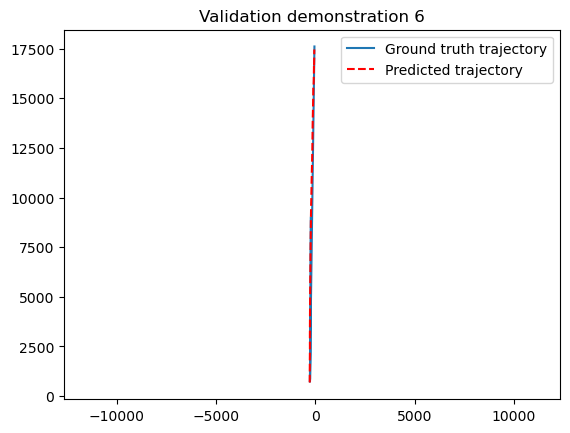

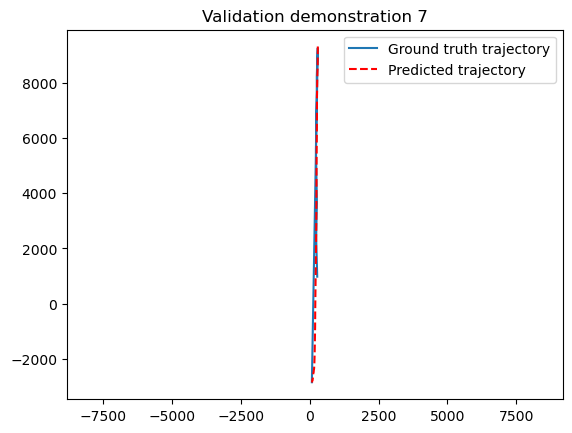

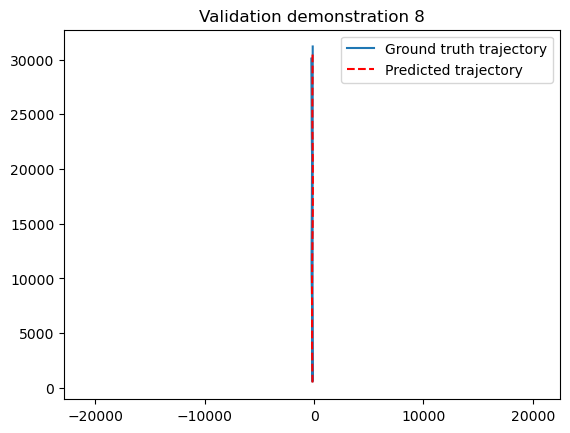

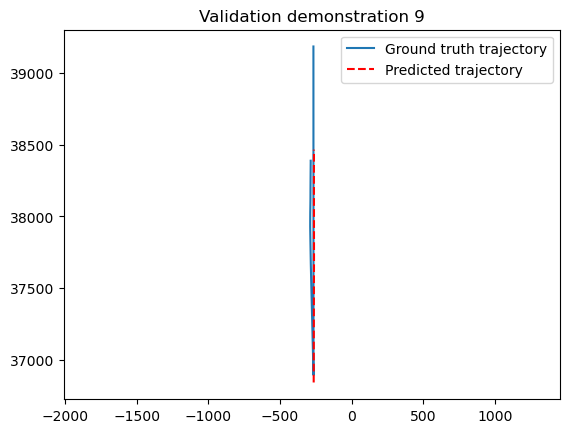

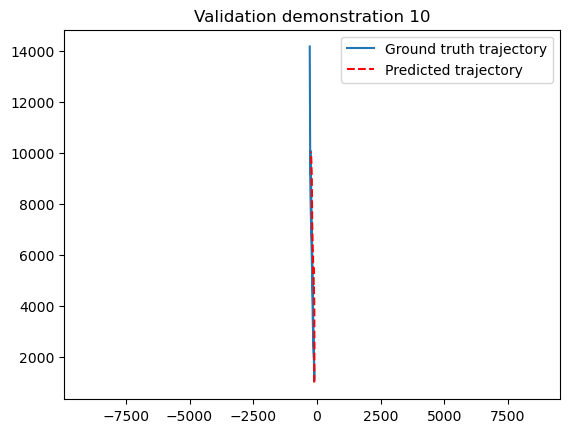

In [45]:
if world_frame:
    first_train = train_demonstrations[0][0]
    first_validation = validation_demonstrations[0][0]
    visualize_prediction(first_train, model, X_train_mean, X_train_std, X_train_mean[0:4], X_train_std[0:4], n_steps_ahead=n_steps_ahead, sim_time=60)
    visualize_prediction(first_validation, model, X_train_mean, X_train_std, X_train_mean[0:4], X_train_std[0:4], n_steps_ahead=n_steps_ahead, sim_time=10)

else:
    for i, demonstration_states in enumerate(train_demonstration_states_line_frame):
        visualize_prediction_line_frame(demonstration_states, model, X_train_mean, X_train_std, Y_train_mean, Y_train_std, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians)
        plt.title(f"Train demonstration {i}")

    for i, demonstration_states in enumerate(validation_demonstration_states_line_frame):
        visualize_prediction_line_frame(demonstration_states, model, X_train_mean, X_train_std, Y_train_mean, Y_train_std, n_steps_ahead, k_closest_vehicles, k_closest_pedestrians)
        plt.title(f"Validation demonstration {i}")
